# Initial Preprocessing for Olist



In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import yaml

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path, 'src'))

from utils import create_folder
# from date_utils import filter_date_state

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [2]:
# Read the raw data from the tables
customers      = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['customers'])
products       = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['products'])
pc_name_trans  = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['pc_name_trans'])
orders         = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['orders'])
order_items    = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['orderitems'])
order_payments = pd.read_csv(proj_path / catalog['base_dir'] / catalog['tables']['orderpayments'])

# Store product categories' translations in a dictionary 
# and translate the product category column in the products table to english
pc_name_trans = pc_name_trans.set_index('product_category_name')['product_category_name_english'].to_dict()
products['product_category_name'] = products['product_category_name'].map(pc_name_trans)

# Join tables together
sales_order = pd.merge(orders, customers, on='customer_id', how='inner')
sales_order_item = order_items.merge(sales_order, on = 'order_id', how = 'left')                     
sales_order_full = sales_order_item.merge(products,on = 'product_id',how = 'inner')
sales_with_payments = sales_order_full.merge(order_payments, on='order_id')

# Convert date column to datatime object
sales_with_payments['order_approved_at'] = pd.to_datetime(sales_with_payments['order_approved_at'], 
                                                          format='%Y-%m-%d') 

sales_with_payments.set_index('order_approved_at', inplace=True)

In [3]:
# Group sales togather, either by week or day
group_freq = 'W' # 'd' for day

sales_with_payments_count = (sales_with_payments.groupby(['product_category_name'])
                       .resample(group_freq)["payment_value"]
                       .count() #sum
                       .reset_index())
create_folder(proj_path / catalog['output_dir']['dir'])
sales_with_payments_count.to_csv(proj_path / catalog['output_dir']['dir'] / catalog['output_dir']['transactions'])

In [4]:
group_freq = 'W' # 'd' for day

sales_with_payments_sum = (sales_with_payments.groupby(['product_category_name'])
                       .resample(group_freq)["payment_value"]
                       .sum() #sum
                       .reset_index())

create_folder(proj_path / catalog['output_dir']['dir'])
sales_with_payments_sum.to_csv(proj_path / catalog['output_dir']['dir'] / catalog['output_dir']['sum_transactions'])

In [5]:
sales_with_payments_sum

,product_category_name,order_approved_at,payment_value
0,agro_industry_and_commerce,2017-01-29,122.84
1,agro_industry_and_commerce,2017-02-05,82.85
2,agro_industry_and_commerce,2017-02-12,153.64
3,agro_industry_and_commerce,2017-02-19,104.85
4,agro_industry_and_commerce,2017-02-26,36.10
...,...,...,...
6027,watches_gifts,2018-08-05,25998.29
6028,watches_gifts,2018-08-12,29020.05
6029,watches_gifts,2018-08-19,25476.77
6030,watches_gifts,2018-08-26,11252.37


In [6]:
# How many of those categories do we have zero sales units
(sales_with_payments_count[(sales_with_payments_count['product_category_name'].isin(params['olist']['product_categories'])) &
                     (sales_with_payments_count['order_approved_at']>= params['olist']['experiment_dates']['train_start']) &
                     (sales_with_payments_count['order_approved_at']<= params['olist']['experiment_dates']['test_end'])]
 .groupby('product_category_name')
 .agg(lambda x: x.eq(0)
      .sum()))

,order_approved_at,payment_value
product_category_name,,
bed_bath_table,0,1
furniture_decor,0,1
health_beauty,0,1
housewares,0,2
sports_leisure,0,2
telephony,0,2
watches_gifts,0,1


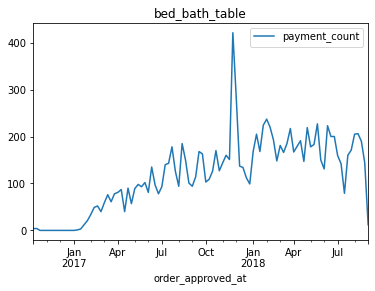

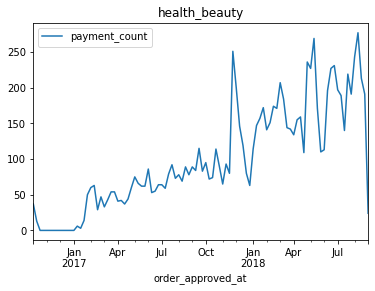

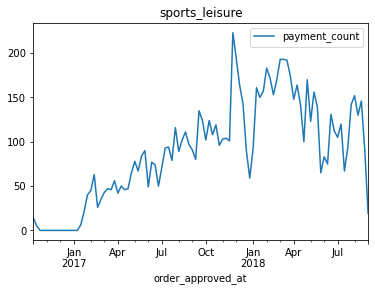

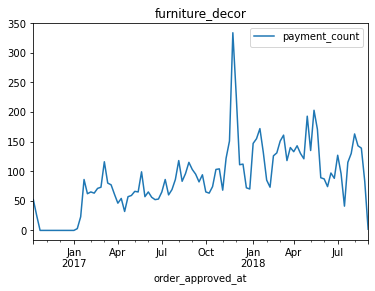

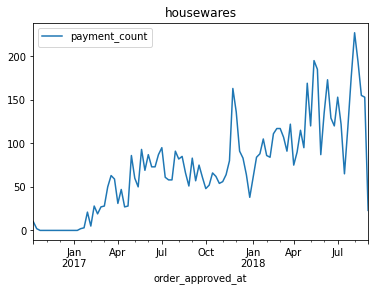

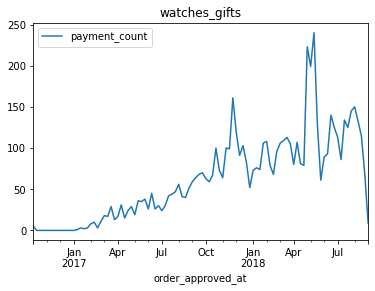

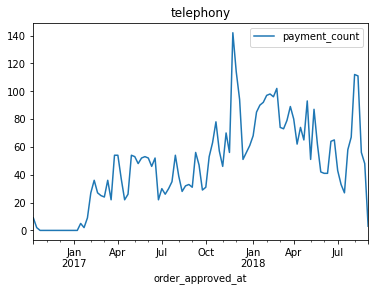

In [7]:
for pc in params['olist']['product_categories']:
    sales_with_payments_count[sales_with_payments_count['product_category_name']==pc].plot(x='order_approved_at', 
                                                                               y='payment_value', title=pc,label='payment_count')

There are only one or two weeks with sales units at 0. This isn't too bad. It's much better than when we had only daily values.

In [8]:
# Look at the sales over time. This helps us determine what dates to consider for the experiment. In most
# cases, there is a flat period which is why we start the experiment January 2017.
# for pc in params['olist']['product_categories']:
#     sales_with_payments[sales_with_payments['product_category_name']==pc].plot(x='order_approved_at', 
#                                                                                y='payment_value',title=pc)